In [1]:
dataset_path = '/data/tfrecords_pe'

In [2]:
import os
import shutil
import json
import jax
import optax
import hashlib
import jax.numpy as jnp
import jax.random as random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from flax import struct
from flax.training import train_state
from tqdm.notebook import tqdm  # Better for Jupyter
import time
from functools import partial
from collections import defaultdict

from typing import NamedTuple, Any

In [3]:
def visualize_reconstructions(state, cached_images, cached_waves, key, num_samples=6):

    # Select random samples from cached batch
    key, subkey = random.split(key)
    batch_size = cached_images.shape[0]
    num_samples = min(num_samples, batch_size)
    indices = random.choice(subkey, batch_size, (num_samples,), replace=False)
    original_images = cached_images[indices]
    
    # Get reconstructions
    key, subkey = random.split(key)
    reconstructed_images, _, _, _ = reconstruct_batch(state, cached_waves[indices], subkey)
    
    # Convert to numpy for plotting
    original_np = np.array(original_images)
    reconstructed_np = np.array(reconstructed_images)

    fig, axs = plt.subplots(num_samples, 2)
    for k in range(num_samples):
        axs[k, 0].imshow(original_np[k, ...])
        axs[k, 1].imshow(reconstructed_np[k, ...])
    plt.show()
    plt.close()
    
    return key

🧪 Running experiment: vae_baseline
📁 Saving to: /data/experiments/vae_baseline_20250905_123021
🔧 Checking GPU availability...
JAX devices: [CudaDevice(id=0)]
Initializing VAE model...
📂 Setting up dataloader...
Found 8 TFRecord files
Total samples: 128
Batches per epoch: 4
Computing global statistics...
Computed stats: mean=32098.3, std=22469.1
Starting training...


Training:   0%|          | 0/5 [00:00<?, ?it/s]

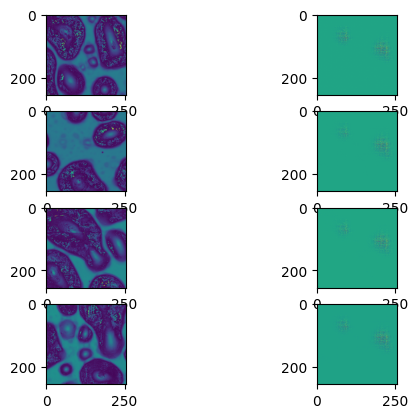

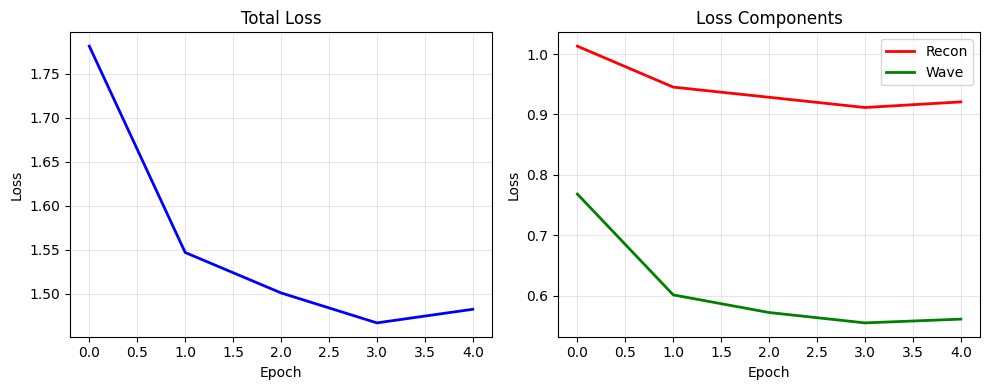

✅ Experiment complete! Results saved to: /data/experiments/vae_baseline_20250905_123021


In [4]:
import matplotlib.pyplot as plt
import os
import json
from datetime import datetime
from models.jax_vae_wavelet import VAE
from polymer.load_tfrecords import Dataloader
import jaxwt as jwt

# =============================================================================
# EXPERIMENT CONFIG
# =============================================================================
config = {
    "experiment_name": "vae_baseline",
    "learning_rate": 0.001,
    "num_epochs": 5,
    "batch_size": 32,
    "base_features": 32,
    "latent_dim": 128,
    "notes": "baseline run with haar wavelets"
}

# Auto-generate experiment directory
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
exp_dir = f"/data/experiments/{config['experiment_name']}_{timestamp}"
os.makedirs(exp_dir, exist_ok=True)

# Save config
with open(f"{exp_dir}/config.json", "w") as f:
    json.dump(config, f, indent=2)

print(f"🧪 Running experiment: {config['experiment_name']}")
print(f"📁 Saving to: {exp_dir}")

# =============================================================================
# SIMPLE LOSS TRACKING
# =============================================================================
losses = []

def plot_losses():
    if len(losses) < 2:
        return
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot([l['total_loss'] for l in losses], 'b-', linewidth=2)
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot([l['recon_loss'] for l in losses], 'r-', label='Recon', linewidth=2)
    plt.plot([l['wave_loss'] for l in losses], 'g-', label='Wave', linewidth=2)
    plt.title('Loss Components')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{exp_dir}/losses.png", dpi=150, bbox_inches='tight')
    plt.show()

# =============================================================================
# ORIGINAL CODE WITH MINIMAL CHANGES
# =============================================================================

class TrainState(train_state.TrainState):
    pass 

@jax.jit
def train_step(
    state_, 
    input_imgs_,
    input_waves_, 
    rng_key,
):
    def loss_fn(params_):
        (x_recon, x_wave, mu, log_var) = state_.apply_fn(
            {'params': params_},
            input_waves_,
            training=True,
            key=rng_key
        )
        
        recon_loss = jnp.mean(jnp.abs(input_imgs_ - x_recon[..., jnp.newaxis]))
        wave_loss = jnp.mean(jnp.abs(input_waves_ - x_wave))
        tot_err = recon_loss + wave_loss
        
        return tot_err, (recon_loss, wave_loss)

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    aux, grads = grad_fn(state_.params)
    tot_loss, (recon_loss, wave_loss) = aux
    
    new_state = state_.apply_gradients(grads=grads)
    return new_state, tot_loss, recon_loss, wave_loss


@jax.jit
def reconstruct_batch(state, input_waves, rng_key):
    (x_recon, x_waves, mu, log_var) = state.apply_fn(
        {'params': state.params},
        input_waves,
        training=False,
        key=rng_key
    )
    return x_recon, x_waves, mu, log_var


if __name__ == "__main__":
    # GPU Check
    print("🔧 Checking GPU availability...")
    print(f"JAX devices: {jax.devices()}")
    
    # Initialize model with config
    print("Initializing VAE model...")
    vae = VAE(base_features=config['base_features'], latent_dim=config['latent_dim'])
    key = random.PRNGKey(42)
    x = random.uniform(key, (1, 128, 128, 4))
    key, init_key, sample_key = random.split(key, 3)
    variables = vae.init(init_key, x, sample_key, training=False)
    
    # Training setup from config
    key = random.key(0)
    key, *subkeys = random.split(key, 4)
    
    params = variables['params']
    tx = optax.adamw(config['learning_rate'])
    state = TrainState.create(apply_fn=vae.apply, params=params, tx=tx)
    
    # Initialize dataloader
    print("📂 Setting up dataloader...")
    dataloader = Dataloader(
        tfrecord_pattern=os.path.join(dataset_path, "*.tfrecord"),
        batch_size=config['batch_size'],
        enable_augmentation=True
    )
    
    batches_per_epoch = dataloader.get_batches_per_epoch()
    jax_ds = dataloader.get_jax_iterator()
    
    print("Starting training...")
    
    for epoch in tqdm(range(config['num_epochs']), desc="Training"):
        epoch_losses = {'recon_loss': [], 'wave_loss': [], 'total_loss': []}
        
        for batch_idx in range(batches_per_epoch):
            subkeys[2], key1, key2 = random.split(subkeys[2], 3)
            batch_ = next(jax_ds)
            perm = random.permutation(key1, config['batch_size'])
            
            permuted_imgs = batch_['features'][perm, ...]
            transformed = jwt.wavedec2(permuted_imgs, "haar", level=1, mode="reflect", axes=(1,2))
            permuted_waves = jnp.concatenate([transformed[0], transformed[1][1], transformed[1][0], transformed[1][2]], axis=-1)
            permuted_waves = jax.lax.stop_gradient(permuted_waves)
            
            state, total_loss, recon_loss, wave_loss = train_step(
                state, permuted_imgs, permuted_waves, key2
            )
            
            epoch_losses['total_loss'].append(float(total_loss))
            epoch_losses['recon_loss'].append(float(recon_loss))
            epoch_losses['wave_loss'].append(float(wave_loss))
        
        # Log epoch averages
        losses.append({
            'epoch': epoch,
            'total_loss': sum(epoch_losses['total_loss']) / len(epoch_losses['total_loss']),
            'recon_loss': sum(epoch_losses['recon_loss']) / len(epoch_losses['recon_loss']),
            'wave_loss': sum(epoch_losses['wave_loss']) / len(epoch_losses['wave_loss'])
        })
        
        # Plot every 10 epochs
        if epoch % 10 == 0:
            plot_losses()
        
        # Visualize reconstructions every 5 epochs
        if epoch % 5 == 0:
            key = visualize_reconstructions(state, permuted_imgs, permuted_waves, key, num_samples=4)
    
    # Save final results
    plot_losses()
    
    # Save model checkpoint
    ckpt = {'model': state.params}
    checkpoint_path = os.path.abspath(f'{exp_dir}/model_checkpoint')
    
    import orbax
    from flax.training import orbax_utils
    orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
    save_args = orbax_utils.save_args_from_target(ckpt)
    orbax_checkpointer.save(checkpoint_path, ckpt, save_args=save_args)
    
    # Save losses as JSON
    with open(f"{exp_dir}/losses.json", "w") as f:
        json.dump(losses, f, indent=2)
    
    print(f'✅ Experiment complete! Results saved to: {exp_dir}')